### Imports

In [148]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import matplotlib.dates as mdates
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
import statsmodels.api as sm


### Clean V1

In [149]:
# Load in v1 data

# Location of files to be processed
data_location = r"C:\Users\pawoo\OneDrive\Documents\Coastal_Hazards_Lab_Stuff\Research_Project_Items_and_Python\SDF\Matlab files\BF_01v1files"

# Initialize an empty DataFrame to store the extracted data
total_v1data = pd.DataFrame()

# Define the range of data logs to be processed
start_log = 217
end_log = 353

# Join all data together into a Pandas dataframe
for data_log_number in range(start_log, end_log + 1):
    data_log_suffix = f"{data_log_number:00}"
    data_log_filename = f"datalog00{data_log_suffix}.txt"
    file_path = os.path.join(data_location, data_log_filename)

    if os.path.isfile(file_path):
        data = pd.read_csv(file_path, sep=',')
        total_v1data = pd.concat([total_v1data, data], ignore_index=True)
    else:
        print(f"File for datalog {data_log_suffix} not found.")

# Combine v1 date and time data into one single datetime column
total_v1data['sampleDate'] = pd.to_datetime(total_v1data['rtcDate'] + " " + total_v1data['rtcTime'], errors='coerce')

# Drop rows with invalid datetime conversions
total_v1data.dropna(subset=['sampleDate'], inplace=True)

# Ensure 'mbar' is numeric and drop rows with invalid 'mbar' data
total_v1data['mbar'] = pd.to_numeric(total_v1data['mbar'], errors='coerce')
total_v1data.dropna(subset=['mbar'], inplace=True)

# Initialize other variables
pressure = total_v1data['mbar']
boardTemp = total_v1data['imu_degC']
sampleNum = total_v1data['count']
sensorTemp = total_v1data['degC']
volts = total_v1data['VIN']
x = total_v1data['aX']
y = total_v1data['aY']
z = total_v1data['aZ']

total_v1data.to_csv('total_v1data.csv', index=False)

# Clean v1 data

# Initialize the previousDate and duration_to_add
previousDate = datetime(year=2023, month=9, day=11)
duration_to_add = timedelta(hours=0, minutes=0, seconds=0)

# Ensure sampleDate is a list of datetime objects
sampleDate = total_v1data['sampleDate'].tolist()

# Process sampleDate list
for i in range(len(sampleDate)):
    sampleDate[i] = sampleDate[i] + duration_to_add
    if sampleDate[i] < (previousDate - timedelta(hours=2)):
        sampleDate[i] = sampleDate[i] - duration_to_add
        duration_to_add = previousDate - datetime(year=2000, month=1, day=1)
        sampleDate[i] = sampleDate[i] + duration_to_add
    previousDate = sampleDate[i]

# Update the dataframe with the cleaned sampleDate
total_v1data['sampleDate'] = sampleDate

# Filter and clean the data
mask = (total_v1data['sampleDate'] <= pd.to_datetime('1-Feb-2024')) & \
       (total_v1data['mbar'] >= 950) & (total_v1data['mbar'] <= 1200)

v1_data_cleaned = total_v1data[mask]

# Assign correct variable names to match v1data.mat as a dataframe
v1_data_update = pd.DataFrame({
    'sampleDate': v1_data_cleaned['sampleDate'],
    'pressure': v1_data_cleaned['mbar'],
    'boardTemp': v1_data_cleaned['imu_degC'],
    'sampleNum': v1_data_cleaned['count'],
    'sensorTemp': v1_data_cleaned['degC'],
    'volts': v1_data_cleaned['VIN'],
    'x': v1_data_cleaned['aX'],
    'y': v1_data_cleaned['aY'],
    'z': v1_data_cleaned['aZ']
})


# Final times is in EST- not yet localized
# Optionally, save the cleaned data to a CSV file
v1_data_update.to_csv("cleaned_v1_data.csv", index=False)



### Clean V2

In [150]:
# Step 1: Read the .dat file and load it into a DataFrame
# Assuming the file is space or tab-delimited (adjust delimiter as needed)
df = pd.read_csv('v2files.dat', delimiter=',', header=None)  # Modify delimiter if it's comma, space, etc.

# Rename columns in place
df.rename(columns={0: 'sampleDate', 1: 'volts', 5 : 'boardTemp', 6 : 'pressure', 7: 'sensorTemp'}, inplace=True)

total_v2data = df.drop(columns=[2, 3, 4, 8, 9])

# Convert columns to appropriate types
total_v2data['pressure'] = pd.to_numeric(total_v2data['pressure'], errors='coerce')
total_v2data['sampleDate'] = pd.to_datetime(total_v2data['sampleDate'], errors='coerce')

# Initialize other variables
pressure = total_v2data['pressure'].tolist()
boardTemp = total_v2data['boardTemp'].tolist()
sensorTemp = total_v2data['sensorTemp'].tolist()
volts = total_v2data['volts'].tolist()
sampleDate = total_v2data['sampleDate'].tolist()


# Define the date threshold
date_threshold = datetime.strptime('14-Sep-2023', '%d-%b-%Y')

# Define the date threshold
date_threshold = datetime.strptime('14-Sep-2023', '%d-%b-%Y')

# Iterate through the data and remove entries based on conditions
i = 0
while i < len(sampleDate):
    # Check if the date is before the threshold or if the pressure is out of range
    if (sampleDate[i] < date_threshold) or (pressure[i] < 950) or (pressure[i] > 1200):
        # Remove corresponding elements from all lists
        del sampleDate[i]
        del pressure[i]
        del boardTemp[i]
        del sensorTemp[i]
        del volts[i]
    else:
        i += 1  # Only increment if no deletion (to avoid skipping elements)


# Create DataFrame from cleaned data
v2_data_update = pd.DataFrame({
    'sampleDate': sampleDate,
    'pressure': pressure,
    'boardTemp': boardTemp,
    'sensorTemp': sensorTemp,
    'volts': volts

})
# Optionally, save the cleaned data to a CSV file
v2_data_update.to_csv("cleaned_v2_data.csv", index=False)



### V1-V2 Differences 

In [151]:
# Read in v1 csv
v1data = pd.read_csv('cleaned_v1_data.csv')

# Parse the sampleDate column as datetime and localize to EST
v1_sampleDate = pd.to_datetime(v1data['sampleDate'])
est = pytz.timezone("EST")
v1_sampleDate = v1_sampleDate.dt.tz_localize(est).astype(np.int64) / 1e9  # Convert to Unix timestamps in seconds
v1_pressure = v1data['pressure']
v1_sensorTemp = v1data['sensorTemp']

# Read in v2 csv
v2data = pd.read_csv('cleaned_v2_data.csv')

# Parse the sampleDate column as datetime and localize to EST
v2_sampleDate = pd.to_datetime(v2data['sampleDate'])
v2_sampleDate = v2_sampleDate.dt.tz_localize(est).astype(np.int64) / 1e9  # Convert to Unix timestamps in seconds
v2_pressure = v2data['pressure']
v2_sensorTemp = v2data['sensorTemp']

# Interpolate v2 onto v1 times
v2_pressure_interp_func = interp1d(v2_sampleDate, v2_pressure, bounds_error=False, fill_value=np.nan)
v2_sensorTemp_interp_func = interp1d(v2_sampleDate, v2_sensorTemp, bounds_error=False, fill_value=np.nan)

# Perform interpolation
v2_pressure_interp = v2_pressure_interp_func(v1_sampleDate)
v2_sensorTemp_interp = v2_sensorTemp_interp_func(v1_sampleDate)

interpolated_dates_est = pd.to_datetime(v1_sampleDate, unit='s').dt.tz_localize('EST', ambiguous='False') - pd.Timedelta(hours = 10)


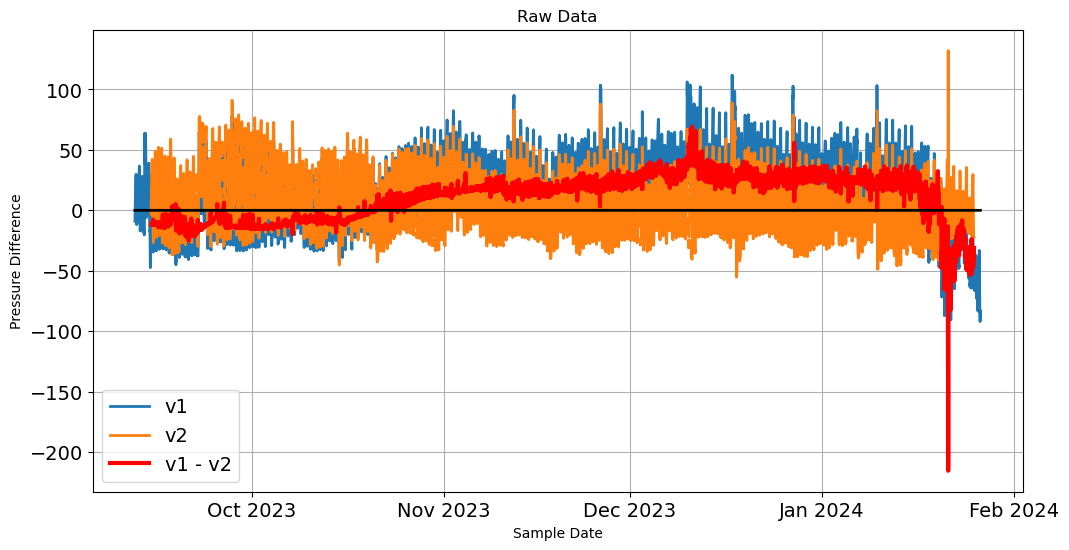

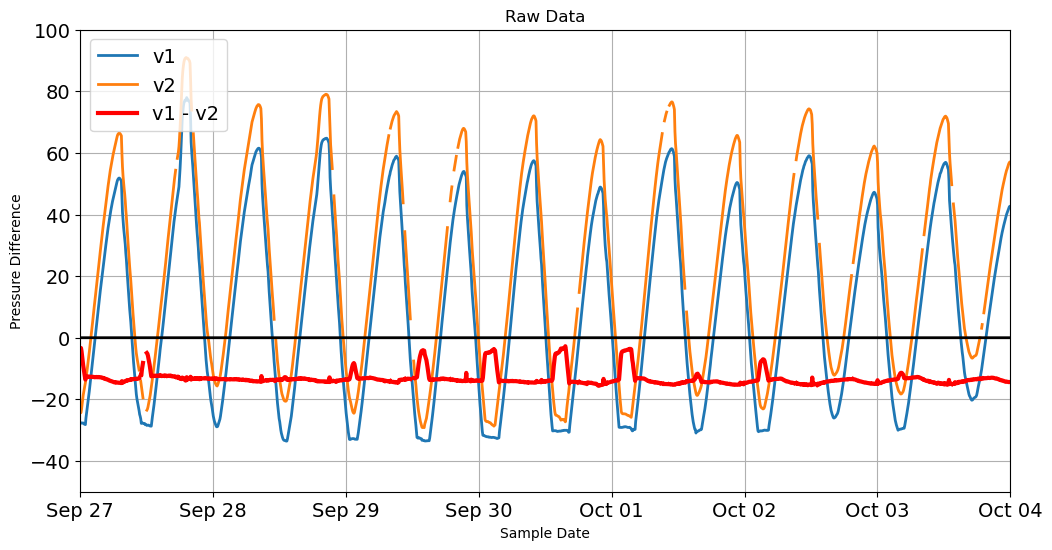

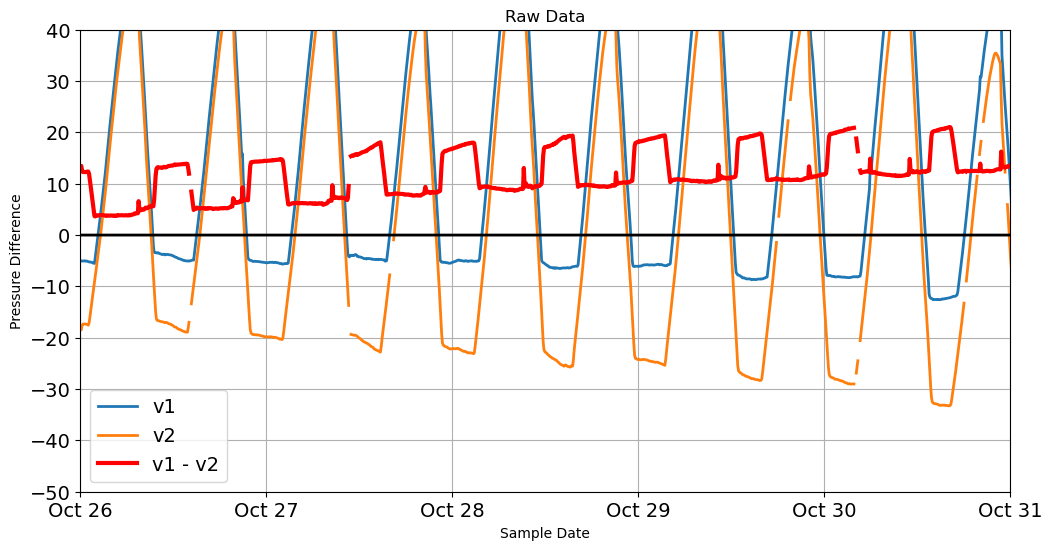

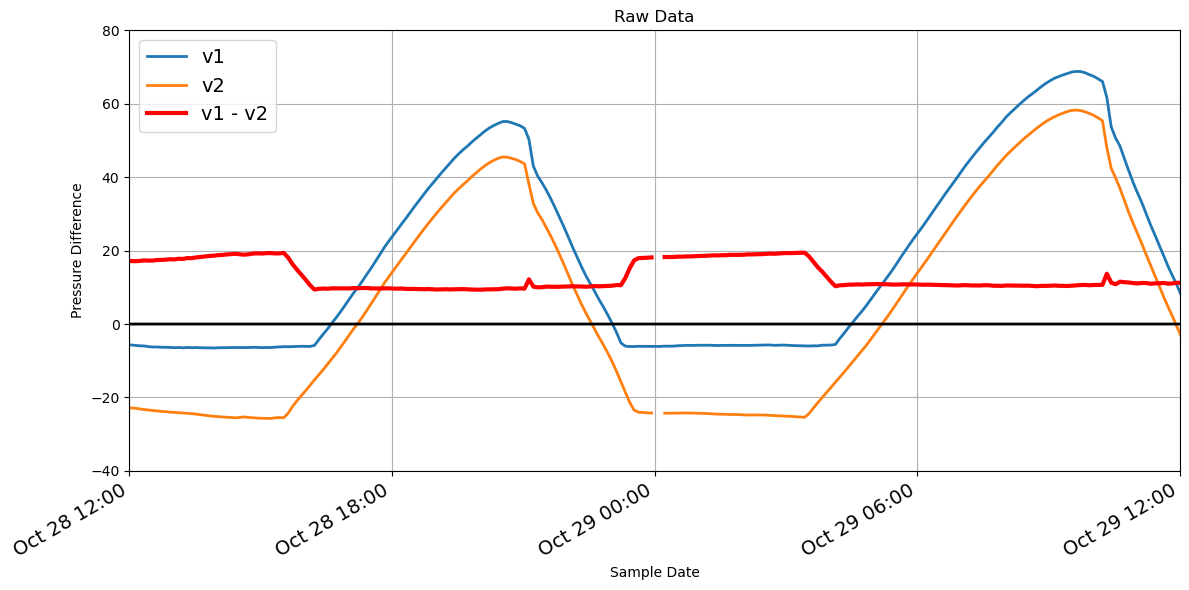

In [152]:
# Initial plot
plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_pressure - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v2_pressure_interp - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v1_pressure - v2_pressure_interp, 'r', linewidth=3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), 'k', linewidth=2)
plt.xlabel('Sample Date')
plt.ylabel('Pressure Difference')
plt.title('Raw Data')
plt.legend(['v1', 'v2', 'v1 - v2'], fontsize=14)
plt.xticks(fontsize=14)

# Set the date format
date_format = mdates.DateFormatter('%b %Y')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

# Zoom in on specific dates 9-28 to 10-03
plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_pressure - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v2_pressure_interp - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v1_pressure - v2_pressure_interp, 'r', linewidth=3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), 'k', linewidth=2)
plt.xlabel('Sample Date')
plt.ylabel('Pressure Difference')
plt.title('Raw Data')
plt.legend(['v1', 'v2', 'v1 - v2'], fontsize=14, loc='upper left')
plt.xticks(fontsize=14)

# Set the date format
date_format = mdates.DateFormatter('%b %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-09-27', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-10-04', tz='EST') - pd.Timedelta(hours=5))

# Set the limits of the y-axis
plt.ylim(-50, 100)

plt.yticks(fontsize=14)
plt.grid(True)
plt.show()



# Zoom in on specific dates 10-25 to 10-31
plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_pressure - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v2_pressure_interp - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v1_pressure - v2_pressure_interp, 'r', linewidth=3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), 'k', linewidth=2)
plt.xlabel('Sample Date')
plt.ylabel('Pressure Difference')
plt.title('Raw Data')
plt.legend(['v1', 'v2', 'v1 - v2'], fontsize=14)
plt.xticks(fontsize=14)

# Set the date format
date_format = mdates.DateFormatter('%b %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-10-26', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-10-31', tz='EST') - pd.Timedelta(hours=5))

# Set the limits of the y-axis
plt.ylim(-50, 40)

plt.yticks(fontsize=14)
plt.grid(True)
plt.show()




# Further zoom in on Oct 28th - 29th at 12 for each day
plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_pressure - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v2_pressure_interp - 1050, linewidth=2)
plt.plot(interpolated_dates_est, v1_pressure - v2_pressure_interp, 'r', linewidth=3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), 'k', linewidth=2)

plt.xlabel('Sample Date')
plt.ylabel('Pressure Difference')
plt.title('Raw Data')
plt.legend(['v1', 'v2', 'v1 - v2'], fontsize=14)
plt.xticks(fontsize=14)

# Set the date format
date_format = mdates.DateFormatter('%b %d %H:%M')
plt.gca().xaxis.set_major_formatter(date_format)


# Set the date locator to display hours (every 6 hours in this example)
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-10-28 12:00:00', tz='EST')- pd.Timedelta(hours=5), pd.Timestamp('2023-10-29 12:00:00', tz='EST') - pd.Timedelta(hours=5))

# Set the limits of the y-axis
plt.ylim(-40, 80)

plt.gcf().autofmt_xdate()  # Auto-format the x-axis for better readability
plt.grid(True)
plt.tight_layout()
plt.show()



### Calibration (1) Plots

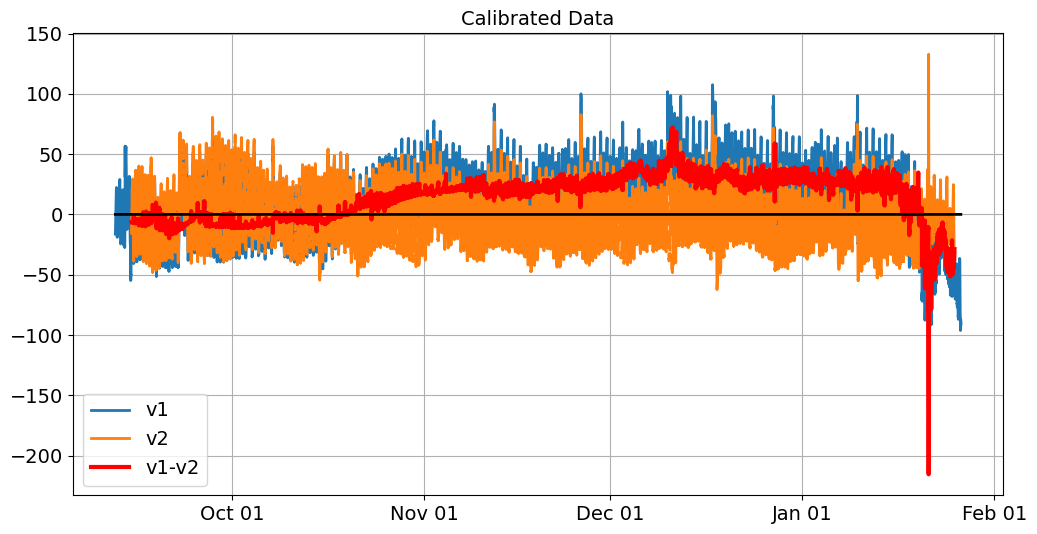

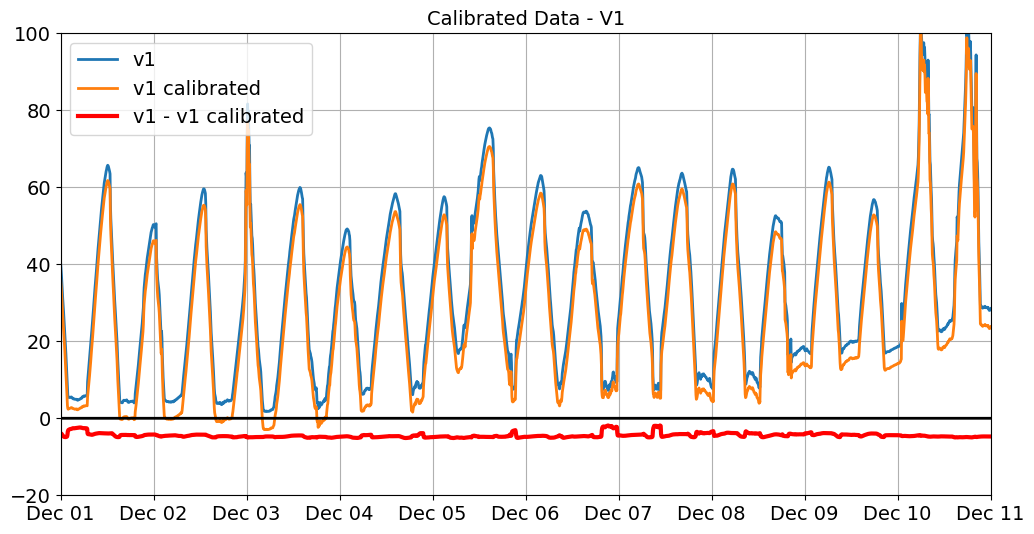

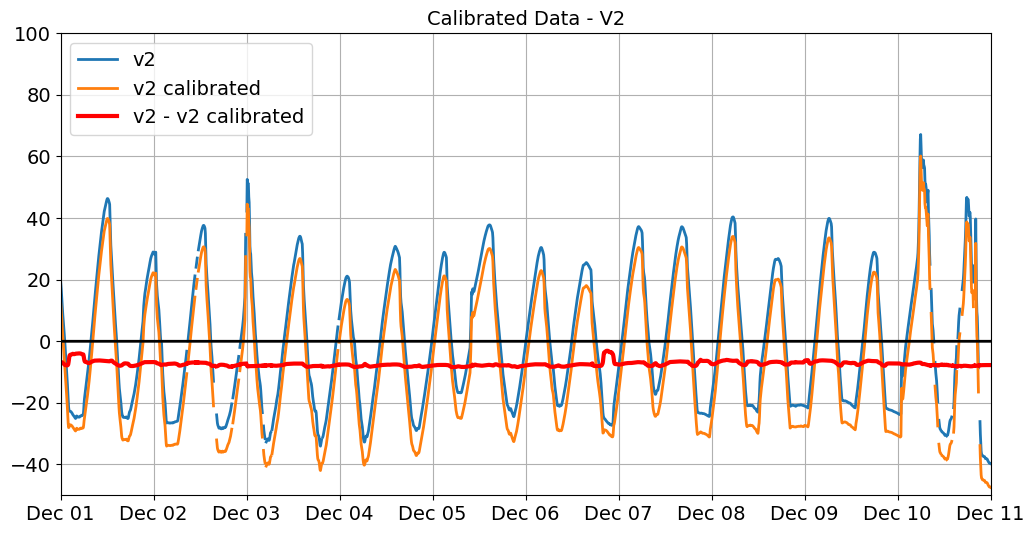

In [153]:

# Calibration values used
v1p_cal = v1_pressure - .262 * v1_sensorTemp
v2p_cal = v2_pressure_interp - .4467 * v2_sensorTemp_interp


# Plot calibrated data
plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1p_cal-1050, linewidth = 2)
plt.plot(interpolated_dates_est, v2p_cal-1050, linewidth=2)
plt.plot(interpolated_dates_est, v1p_cal-v2p_cal, color='r', linewidth = 3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), color='k', linewidth = 2)
plt.grid(True)

# Set the date format
date_format = mdates.DateFormatter('%b %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

# Set the date locator to display dates every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['v1', 'v2', 'v1-v2'], fontsize = 14)
plt.title('Calibrated Data', fontsize = 14)

plt.show()


## Cal vs. Uncal Zoom in - V1 

plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_pressure - 1050, linewidth = 2)
plt.plot(interpolated_dates_est, v1p_cal-1050, linewidth=2)
plt.plot(interpolated_dates_est, v1p_cal-v1_pressure, color='r', linewidth = 3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), color='k', linewidth = 2)
plt.grid(True)

# Set the date format
date_format = mdates.DateFormatter('%b %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['v1', 'v1 calibrated', 'v1 - v1 calibrated'], fontsize = 14)
plt.title('Calibrated Data - V1', fontsize = 14)

# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-12-01', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-12-11', tz='EST') - pd.Timedelta(hours=5))

# Set the limits of the y-axis
plt.ylim(-20, 100)



## Cal vs. Uncal Zoom in - V2

plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v2_pressure_interp - 1050, linewidth = 2)
plt.plot(interpolated_dates_est, v2p_cal-1050, linewidth=2)
plt.plot(interpolated_dates_est, v2p_cal-v2_pressure_interp, color='r', linewidth = 3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), color='k', linewidth = 2)
plt.grid(True)

# Set the date format
date_format = mdates.DateFormatter('%b %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['v2', 'v2 calibrated', 'v2 - v2 calibrated'], fontsize = 14)
plt.title('Calibrated Data - V2', fontsize = 14)

# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-12-01', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-12-11', tz='EST') - pd.Timedelta(hours=5))

# Set the limits of the y-axis
plt.ylim(-50, 100)



plt.show()


(-20.0, 100.0)

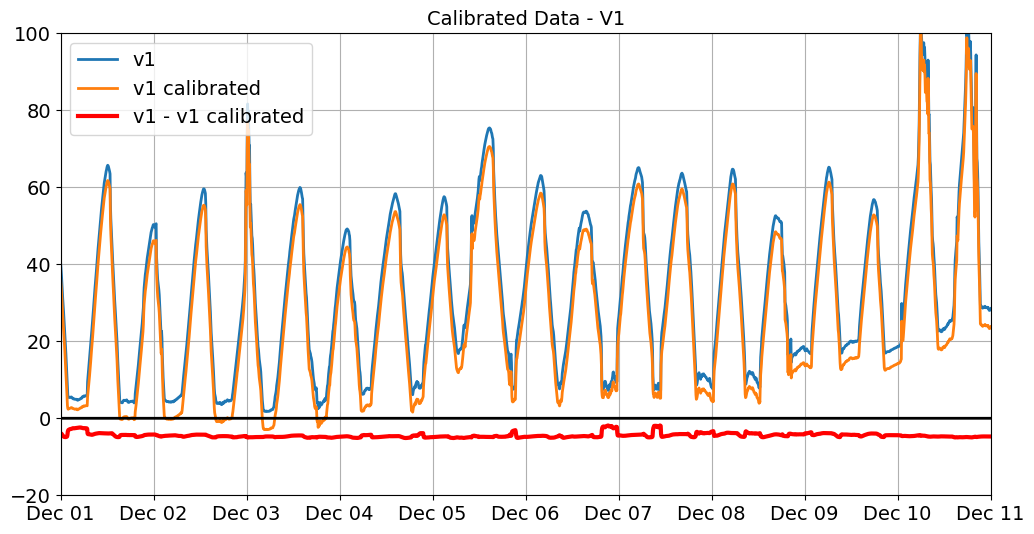

In [154]:
## Cal vs. Uncal Zoom in - V1 

plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_pressure - 1050, linewidth = 2)
plt.plot(interpolated_dates_est, v1p_cal-1050, linewidth=2)
plt.plot(interpolated_dates_est, v1p_cal-v1_pressure, color='r', linewidth = 3)
plt.plot(interpolated_dates_est, np.zeros_like(interpolated_dates_est), color='k', linewidth = 2)
plt.grid(True)

# Set the date format
date_format = mdates.DateFormatter('%b %d')
plt.gca().xaxis.set_major_formatter(date_format)

# Set the date locator to display dates every day
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['v1', 'v1 calibrated', 'v1 - v1 calibrated'], fontsize = 14)
plt.title('Calibrated Data - V1', fontsize = 14)

# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-12-01', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-12-11', tz='EST') - pd.Timedelta(hours=5))

# Set the limits of the y-axis
plt.ylim(-20, 100)





### Drift Correction 

In [155]:

# Read in v1 csv
v1data = pd.read_csv('cleaned_v1_data.csv')
v1_sampleDate = pd.to_datetime(v1data['sampleDate'])

# Localize the timezone and handle nonexistent and ambiguous times
v1_sampleDate = v1_sampleDate.dt.tz_localize('EST', ambiguous=False, nonexistent='shift_backward')

# Convert the EST timezone to UTC
v1_sampleDate_utc = v1_sampleDate.dt.tz_convert('UTC')

# Subtract 5 hours from the UTC time to get EST
v1_sampleDate_utc_minus_5 = v1_sampleDate_utc - pd.Timedelta(hours=5)

v1_sampleDate_utc = v1_sampleDate_utc_minus_5

# Convert the dates to nanoseconds since epoch for interpolation
v1_sampleDate_utc_numeric = v1_sampleDate_utc.view('int64')

# Load the comparison data
comparison_data = pd.read_csv('v1v2comparison-data.csv')

# Convert 'date' column to datetime and localize to UTC
comparison_data['date'] = pd.to_datetime(comparison_data['date'], utc=True)

# Convert 'atm_pressure' to numeric and filter NaN values
comparison_data['atm_pressure'] = pd.to_numeric(comparison_data['atm_pressure'], errors='coerce')
p = comparison_data['atm_pressure'].dropna()
d = comparison_data['date'][~comparison_data['atm_pressure'].isna()]

# Convert the dates in 'comparison_data' to nanoseconds since epoch
d_numeric = d.view('int64')

# Perform interpolation
atmos = np.interp(v1_sampleDate_utc_numeric, d_numeric, p)

v1_ft = (((v1p_cal - atmos) * 100 / (1020 * 9.81)) * 3.28084)
v2_ft = (((v2p_cal - atmos) * 100 / (1020 * 9.81)) * 3.28084) 

## Diffs calc
# Convert the 'sampleDate' column to datetime
v1data['sampleDate'] = pd.to_datetime(v1data['sampleDate'])

# Localize the timezone and handle nonexistent and ambiguous times
v1data['sampleDate'] = v1data['sampleDate'].dt.tz_localize('EST', ambiguous=False, nonexistent='shift_backward')


# Convert the EDT timezone to UTC
v1data['sampleDate_utc'] = v1data['sampleDate'].dt.tz_convert('UTC') 

# Calculate differences in minutes between consecutive timestamps
v1data["diffs"] = (v1data["sampleDate_utc"] - v1data["sampleDate_utc"].shift(1)).dt.total_seconds() / 60

# Print the diffs column
ddt = v1data['diffs']

# Calculate differences for df1 and df2
diffs_df1 = np.diff(v1_ft)
diffs_df2 = np.diff(v2_ft)
df1 = np.insert(diffs_df1, 0, np.nan)
df2 = np.insert(diffs_df2, 0, np.nan)

# Insert NaN at the beginning to match the original size of v1_sampleDate (initialize ddt_minutes)
 #ddt_minutes = np.insert(diffs, 0, np.nan)

# Ensure that df1 and df2 are float arrays
df1 = df1.astype(float)
df2 = df2.astype(float)


# Perform element-wise division, safely handling NaN values
df1_perMin = df1 / ddt
df2_perMin = df2 / ddt


# Set NaN for df1_perMin and df2_perMin based on conditions
v1_ft[df1_perMin > 0.1] = np.nan
v2_ft[df2_perMin > 0.1] = np.nan


C:\Users\pawoo\AppData\Local\Temp\ipykernel_41972\584863940.py:17: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  v1_sampleDate_utc_numeric = v1_sampleDate_utc.view('int64')
C:\Users\pawoo\AppData\Local\Temp\ipykernel_41972\584863940.py:31: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  d_numeric = d.view('int64')


In [156]:
# Read in v1 csv
v1_sampleDate = interpolated_dates_est

v1_ft = np.array(v1_ft)  # Convert to numpy array
v2_ft = np.array(v2_ft)


# Initialize variables
done = False
i = 0  # Start index at 0 (Python uses 0-based indexing)
v1_baseline = np.ones(len(v1_ft)) * np.nan  # Pre-fill with NaN
v2_baseline = np.ones(len(v2_ft)) * np.nan
pctdone = 0


# Total number of entries
total_len = len(v1_ft)

print(f'Percent done\n{pctdone:02}')

# Start looping through rolling 2-day windows
while not done:
    # Calculate time differences from the current timestamp
    time_diff = interpolated_dates_est[i] - interpolated_dates_est

    # Create the rolling mask for the 2-day window
    rolling_mask = (time_diff <= pd.Timedelta(days=2)) & (time_diff >= pd.Timedelta(days=0))

    # Find the last index in the rolling window
    lix = np.where(rolling_mask)[0][-1]

    # Calculate the 4th percentile of values in the rolling window and assign it to baseline
    v1_baseline[lix] = np.nanquantile(v1_ft[rolling_mask], 0.04)
    v2_baseline[lix] = np.nanquantile(v2_ft[rolling_mask], 0.04)

    current_pctdone = np.floor(100 * lix / len(v1_ft))
    if current_pctdone > pctdone:
        pctdone = current_pctdone
        print(f'\r{pctdone:02.0f}', end='')

    if lix == len(v1_ft) - 1:
        done = True
    i += 1

print(f'\r{100:02.0f}', end='\n')



c:\Users\pawoo\anaconda3\envs\v1v2_comp\Lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


Percent done
00
100


Text(0.5, 1.0, 'V2 Calibrated Data vs. Rolling Percentile')

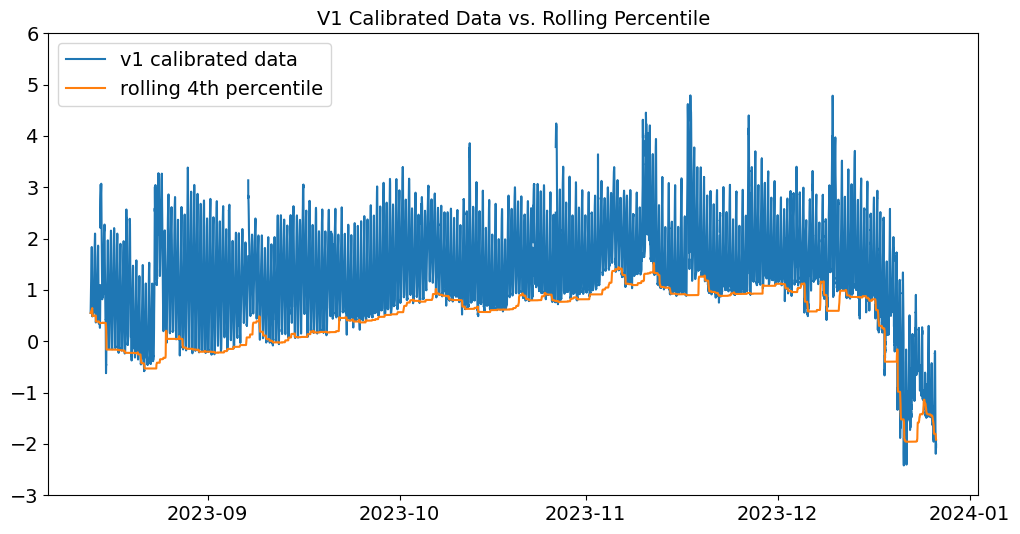

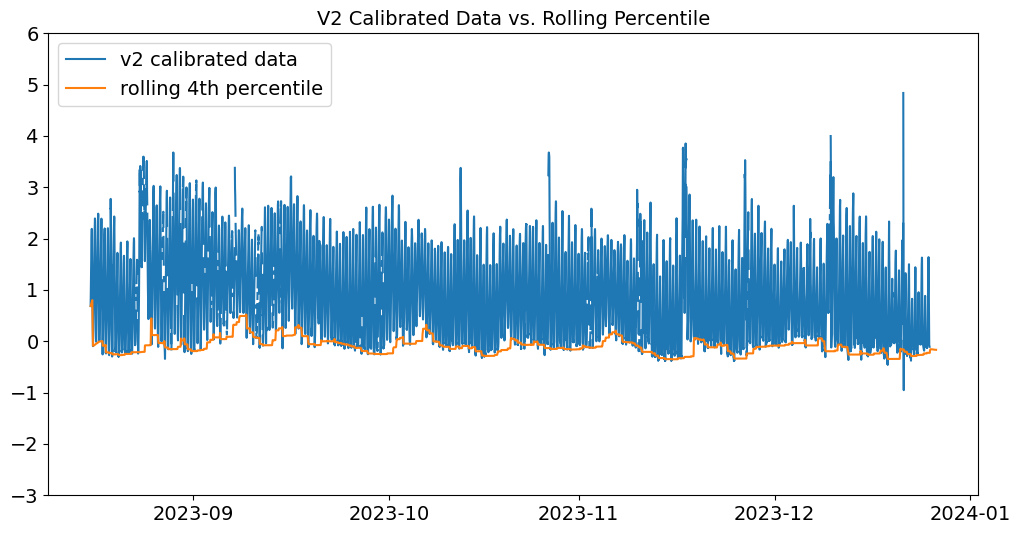

In [157]:
## Rolling Baselines Plots

# Plot drift corrected data

plt.figure(figsize=(12, 6))
plt.plot(v1_sampleDate, v1_ft)
plt.plot(v1_sampleDate, v1_baseline)
plt.ylim(-3, 6)


# Set the date locator to display dates every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['v1 calibrated data', 'rolling 4th percentile'], fontsize = 14)
plt.title('V1 Calibrated Data vs. Rolling Percentile', fontsize = 14)


plt.figure(figsize=(12, 6))
plt.plot(v1_sampleDate, v2_ft)
plt.plot(v1_sampleDate, v2_baseline)
plt.ylim(-3, 6)


# Set the date locator to display dates every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['v2 calibrated data', 'rolling 4th percentile'], fontsize = 14)
plt.title('V2 Calibrated Data vs. Rolling Percentile', fontsize = 14)


In [158]:
# Rate of change of the baseline in ft/min

    
db1_diffs = np.diff(v1_baseline)
db1 = np.insert(db1_diffs, 0, np.nan)  # Insert NaN at the start
db2_diffs = np.diff(v2_baseline)
db2 = np.insert(db2_diffs, 0, np.nan)


db1_perMin = db1 / ddt 
db2_perMin = db2 / ddt

# Select the non-zero values, and always keep the last point
v1_nonzero_mask = (db1_perMin != 0).astype(float)
v2_nonzero_mask = (db2_perMin != 0).astype(float)
v1_nonzero_mask.iloc[-1] = 1
v2_nonzero_mask.iloc[-1] = 1

v1_lq = np.nanquantile(v1_baseline, 0.01, interpolation='linear')
v1_uq = np.nanquantile(v1_baseline, 0.75, interpolation='linear')
v2_lq = np.nanquantile(v2_baseline, 0.01, interpolation='linear')
v2_uq = np.nanquantile(v2_baseline, 0.75, interpolation='linear')

# Logical indexing conditions for change points
v1_changePts = v1_baseline[(v1_nonzero_mask > 0) & (v1_baseline >= v1_lq) & (v1_baseline <= v1_uq)]
v2_changePts = v2_baseline[(v2_nonzero_mask > 0) & (v2_baseline >= v2_lq) & (v2_baseline <= v2_uq)]

# Select the change points and corresponding dates
v1_changePtDates = interpolated_dates_est[(v1_nonzero_mask > 0) & (v1_baseline >= v1_lq) & (v1_baseline <= v1_uq)]
v2_changePtDates = interpolated_dates_est[(v2_nonzero_mask > 0) & (v2_baseline >= v2_lq) & (v2_baseline <= v2_uq)]

v1_cpd = (v1_changePtDates - v1_changePtDates.iloc[0]).dt.total_seconds() / 60.0
v2_cpd = (v2_changePtDates - v2_changePtDates.iloc[0]).dt.total_seconds() / 60.0


# Calculate span for Lowess smoothing (2 weeks divided by last element of cpd)
span1 = 13440 / v1_cpd.iloc[-1]
span2 = 13440 / v2_cpd.iloc[-1]


# Interpolate to smooth the baseline
v1_sampleDate_num = (interpolated_dates_est - v1_changePtDates.iloc[0]).dt.total_seconds() / 60.0
# Perform lowess smoothing
lowess_result1 = sm.nonparametric.lowess(v1_changePts, v1_cpd, frac=span1, it=50)
lowess_result2 = sm.nonparametric.lowess(v2_changePts, v2_cpd, frac=span2,it=50)


# Example input data (replace with your actual data)
v1_changePtsSmoothed = lowess_result1[:, 1]  # From the LOWESS smoothing result
v2_changePtsSmoothed = lowess_result2[:, 1]  # From the LOWESS smoothing result

# Interpolate to smooth the baseline
v1_sampleDate_num = (interpolated_dates_est - v1_changePtDates.iloc[0]).dt.total_seconds() / 60.0

# Interpolate using numpy.interp
v1_baseline_int = np.interp(v1_sampleDate_num, v1_cpd, v1_changePtsSmoothed)

# If you also want to interpolate v2 using numpy.interp
v2_baseline_int = np.interp(v1_sampleDate_num, v2_cpd, v2_changePtsSmoothed)

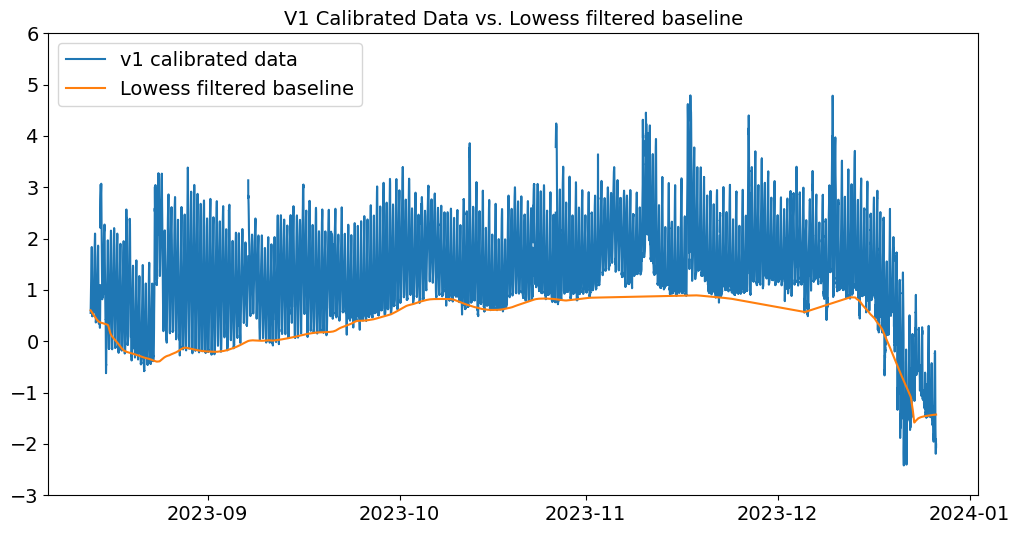

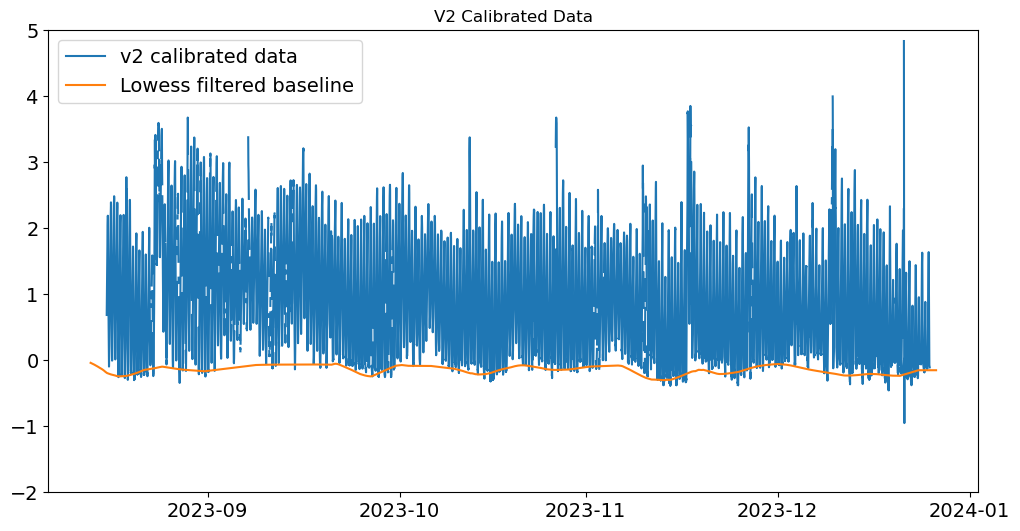

In [159]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(interpolated_dates_est, v1_ft)
plt.plot(interpolated_dates_est, v1_baseline_int)
plt.ylim(-3, 6)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['v1 calibrated data', 'Lowess filtered baseline'], fontsize=14)
plt.title('V1 Calibrated Data vs. Lowess filtered baseline', fontsize=14)

plt.figure(figsize=(12, 6))
plt.plot(v1_sampleDate, v2_ft)
plt.plot(v1_sampleDate, v2_baseline_int)
plt.ylim(-2, 5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['v2 calibrated data', 'Lowess filtered baseline'], fontsize=14)
plt.title('V2 Calibrated Data')

plt.show()

### Post Lowess Filtering Adjustments and Plotting

Text(0.5, 1.0, 'Drift and Height Corrected Water Heights')

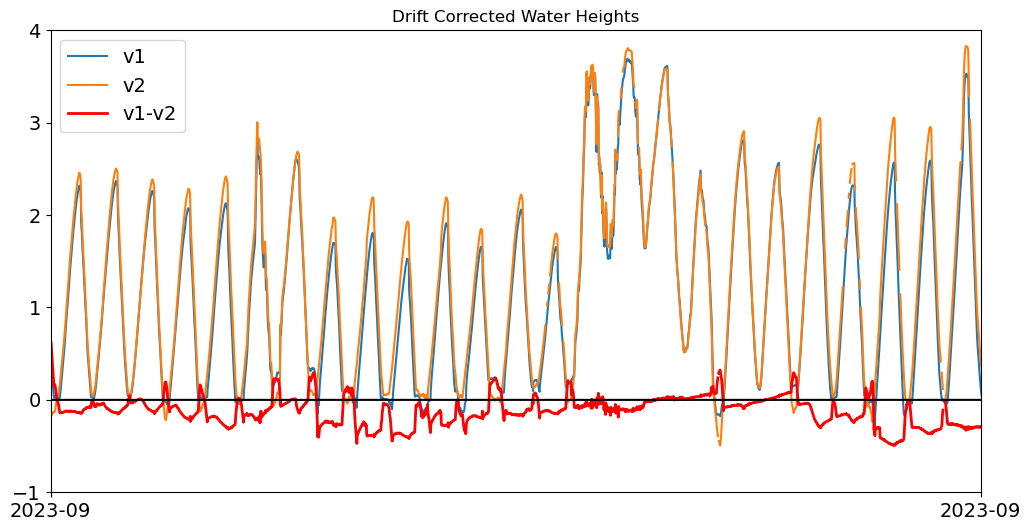

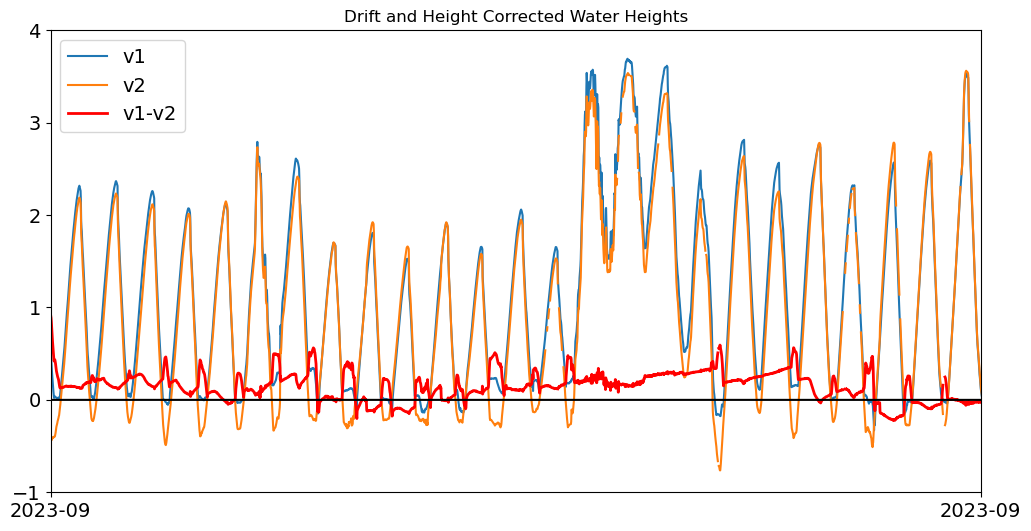

In [160]:
# Subtract the baseline from the data to correct for the drift 
v1p_driftCorrected = v1_ft - v1_baseline
v2p_driftCorrected = v2_ft - v2_baseline



# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v1_sampleDate, v1p_driftCorrected)
plt.plot(v1_sampleDate, v2p_driftCorrected)
plt.plot(v1_sampleDate, v1p_driftCorrected - v2p_driftCorrected, color='r', linewidth = 2)
plt.plot(v1_sampleDate, np.zeros(np.size(v1_sampleDate)), color='k')
plt.ylim(-1, 4)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-09-15', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-09-28', tz='EST') - pd.Timedelta(hours=5))
plt.legend(['v1', 'v2', 'v1-v2'], fontsize=14)
plt.title('Drift Corrected Water Heights')



# with height correction for v2 
v2p_driftCorrectedOffset = v2p_driftCorrected - 0.27

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v1_sampleDate, v1p_driftCorrected)
plt.plot(v1_sampleDate, v2p_driftCorrectedOffset)
plt.plot(v1_sampleDate, v1p_driftCorrected - v2p_driftCorrectedOffset, color='r', linewidth = 2)
plt.plot(v1_sampleDate, np.zeros(np.size(v1_sampleDate)), color='k')
plt.ylim(-1, 4)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Set the limits of the x-axis to zoom in on the specified dates
plt.xlim(pd.Timestamp('2023-09-15', tz='EST') - pd.Timedelta(hours=5), pd.Timestamp('2023-09-28', tz='EST') - pd.Timedelta(hours=5))
plt.legend(['v1', 'v2', 'v1-v2'], fontsize=14)
plt.title('Drift and Height Corrected Water Heights')
